In [1]:
#update compared to trial 1: target values uniformly distributed every trial again!

import copy
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import keras
from keras import initializers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.constraints import max_norm
from scipy.stats import pearsonr
from scipy.stats import expon

from time import time
import math

import random
from scipy.misc import comb

Using TensorFlow backend.


In [2]:
### TUNING PARAMETERS ###

observations = 599                    # Sample construction
X_val_size = 99
n_split = 5
                      
N_nodes = [1, 2, 3]                    # Design MLP                       
t=0
H_layers = [1, 2, 3, 5, 10]


m = 0                                  # Distribution parameters
sd = 1               
alpha = 0.5
beta = 0.5
lambd = 1.5
a = 0.25
b = 0.75

                                       # Grid search hyperparameters
batch_size = [10, 25, 50, 100]
epochs = [50, 100, 500]

dropout_rate = [i/5 for i in range(0,5)]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
weight_constraint = [0, 3, 5]

neurons = [1, 2, 3, 4, 5, 10, 20, 30]

                                       #grid_search or random_search?
search = "random_search"
n_iter_search = 10

t_size = 0.4

In [3]:
### FUNCTIONS ###

def create_dataset():
    x = np.array([[random.expovariate(lambd) for i in range(N_nodes[t])] for i in range(0, observations+1)])
    #y = np.array([0.95*i/observations+0.05 for i in range(0,observations+1)])
    
    #check dimensionality
    print('dimensionality of x :', np.shape(x))
    #print('dimensionality of y: ', np.shape(y))
    
    #sort
    x_sorted = np.sort(x,0)

    #correlation
    #for i in range(N_nodes[t]):
    #    print("correlation for " +str(N_nodes[t])+ ": ",pearsonr(x_sorted[:,0], y))
    
    print('\n')
    #return (x_sorted, y)
    return x_sorted

def create_targetset():
    #x = np.array([[random.expovariate(lambd) for i in range(N_nodes[t])] for i in range(0, observations+1)])
    #y = np.array([0.95*i/observations+0.05 for i in range(0,observations+1)])
    y = np.sort(np.array([random.uniform(0,1) for i in range(0,observations+1)]))
    
    #check dimensionality
    #print('dimensionality of x :', np.shape(x))
    print('dimensionality of y: ', np.shape(y))
    
    #sort
    #x_sorted = np.sort(x,0)

    #correlation
    #for i in range(N_nodes[t]):
    #    print("correlation for " +str(N_nodes[t])+ ": ",pearsonr(x_sorted[:,0], y))
    
    print('\n')
    #return (x_sorted, y)
    return y

def scale(x):
    ### scale ###
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    print("mean is: ", mean)
    print("variance is: ", var)

    x_scaled = np.array([(i-mean)/np.sqrt(var) for i in x])
    
    print('\n')
    return x_scaled


def plot_dataset(x, y):
    
    for i in range(N_nodes[t]):
        plt.scatter(x[:,i], y, c=y)
        plt.ylabel('Cumulative Probability < RV value')
        plt.xlabel('Random Variable (RV) value')
        plt.plot(x[:,i], expon.cdf(x[:,i], scale=1/lambd), label="actual CDF")
        plt.colorbar(ticks=np.linspace(min(y), max(y), 10, endpoint=True))
        plt.show()
    

def plot_cdf(X_train, Y_train, X_test, Y_test, X_train_scaled, X_test_scaled, predictions):
        for i in range(N_nodes[t]):
            plt.scatter(X_test[:,i], Y_test, label='test set')
            plt.scatter(X_test[:,i], predictions, label='fitted set')
            plt.scatter(X_test[:,i], expon.cdf(X_test[:,i],scale=1/lambd), label="actual CDF")

            plt.ylabel('Cumulative Probability < RV value')
            plt.xlabel('Random Variable (RV) value')
            plt.legend()
            plt.show()
        
def create_model(H_layers=1, optimizer='Adam', init=initializers.RandomNormal(mean=0, stddev=0.25, seed=None), activation='sigmoid', dropout_rate=0.0, learn_rate=0.01, neurons=1, weight_constraint=0):
#def create_model(optimizer, init, dropout_rate, learn_rate, activation, neurons, weight_constraint):
    ### CREATE MODEL ###
    MLP = Sequential()
    #MLP.add(Dropout(dropout_rate, input_shape=(N_nodes[t],)))
    MLP.add(Dense(neurons, input_dim=N_nodes[t], kernel_initializer=init, activation=activation, kernel_constraint=max_norm(weight_constraint)))    #hidden layer
    #MLP.add(Dropout(dropout_rate))
    for h in range(1,H_layers):                                                                     #multiple hidden layers
        MLP.add(Dense(neurons, kernel_initializer=init, activation=activation, kernel_constraint=max_norm(weight_constraint)))
        #MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(1, kernel_initializer=init, activation='sigmoid'))                                 #output layer
    MLP.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return MLP

def train_ANN(search, X_train, Y_train, X_test):
    
    model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, verbose=0)
    print('Keras wrapper done')
    param = dict(epochs=epochs, batch_size=batch_size, neurons=neurons, H_layers=H_layers, learn_rate=learn_rate, weight_constraint=weight_constraint)
    #param = dict(neurons=neurons, H_layers=H_layers, learn_rate=learn_rate, weight_constraint=weight_constraint)
    
    if (search == 'random_search'):
        print('RANDOM SEARCH')
        grid = RandomizedSearchCV(estimator=model, param_distributions=param, n_iter=n_iter_search, n_jobs=1)
        print('Grid is prepared')
        start = time()
        grid.fit(X_train, Y_train)
        #grid.fit(X_train, Y_train, batch_size=500, epochs=1000)
        print("RandomizedSearchCV took %.2f seconds for %d candidates"
              " parameter settings." % ((time() - start), n_iter_search))
    else:
        print('GRIDSEARCH')
        grid = GridSearchCV(estimator=model, param_grid=param, n_jobs=1)
        print('Grid is prepared')
        start = time()
        grid.fit(X_train, Y_train)
        #grid.fit(X_train, Y_train, batch_size=500, epochs=1000)
        print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
              % (time() - start, len(grid.cv_results_['params'])))

    # summarize results (smallest loss?)
    print("Best: %f using %s" % (-grid.best_score_, grid.best_params_))
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    params = grid.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (-mean, stdev, param))
    
    predictions = grid.best_estimator_.predict(X_test)
    
    print('\n')
    return (grid, predictions)

def run_ANN(X_train, Y_train, X_test):
    
    model = create_model(H_layers=H_layers, learn_rate=learn_rate, neurons=neurons, weight_constraint=weight_constraint)
    print('Keras wrapper done')
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
    predictions = model.predict(X_test)
    
    print('\n')
    return (model, predictions)

def activation_function(x):
    return 1/(1+math.exp(-x))

### CHECK PROCEDURE ON TEST SET ###

def run_ANN_manually(X_val, X_val_scaled):
    #assuming biases are included
    b = 0
    k = 0
    #print('k', k)
    temp_saved = np.zeros([len(X_val_scaled), H_layers+1, neurons])
    predictions = np.zeros([len(X_val_scaled)])
    #print('temp_saved', temp_saved)
    while (H_layers-k)>=0:
        #print('while (H_layers-k)>=0:' ,H_layers-k)
        if (k==0):
            #print('k==0')
            for i in range(len(X_val_scaled)):
                #print('i', i)
                for j in range(neurons):
                    #print('j', j)
                    for l in range(N_nodes[t]):
                        #print('l', l)
                        temp_saved[i][k][j] += X_val_scaled[i][l]*weights[b][l][j]
                        #print('temp_saved', temp_saved)
                    temp_saved[i][k][j] += 1*weights[b+1][j]
                    #print('temp_saved', temp_saved)
                    temp_saved[i][k][j] = activation_function(temp_saved[i][k][j])
            #print('temp_saved', temp_saved)
            b += 2
            k += 1
        elif((H_layers-k)>0 and k!=0):
            #print('(H_layers-k)>0 and k!=0')
            #print('k', k)
            for i in range(len(X_val_scaled)):
                #print('i', i)
                for j in range(neurons):
                    #print('j', j)
                    for l in range(neurons):
                        #print('l', l)
                        temp_saved[i][k][j] += temp_saved[i][k-1][l]*weights[b][l][j]
                        #print('temp_saved', temp_saved)
                    temp_saved[i][k][j] += 1*weights[b+1][j]
                    #print('1*weights[k+2][j]', 1*weights[k+2][j])
                    #print('temp_saved', temp_saved)
                    temp_saved[i][k][j] = activation_function(temp_saved[i][k][j])
            #print('temp_saved', temp_saved)
            b += 2
            k += 1
        elif(H_layers-k)==0:
            #print('(H_layers-k)==0')
            #print('k', k)
            for i in range(len(X_val_scaled)):
                #print('i', i)
                for l in range(neurons):
                    #print('l', l)
                    temp_saved[i][k][0] += temp_saved[i][k-1][l]*weights[b][l][0]
                    predictions[i] += temp_saved[i][k-1][l]*weights[b][l][0]
                    #print('temp_saved', temp_saved)
                temp_saved[i][k][0] += 1*weights[b+1][0]
                predictions[i] += 1*weights[b+1][0]
                #print('temp_saved', temp_saved)
                temp_saved[i][k][0] = activation_function(temp_saved[i][k][0])
                predictions[i] = activation_function(predictions[i])
            #print('temp_saved', temp_saved)
            k += 1                                                     #stop while-loop

    plot_cdf(X_test, Y_test, X_val, Y_val, X_test_scaled, X_val_scaled, predictions)

    return (temp_saved, predictions)

def derivative_sigmoid(x):
    return 1/(1+math.exp(-x))*(1-1/(1+math.exp(-x)))



dimensionality of x : (600, 1)


Simulations
dimensionality of y:  (600,)




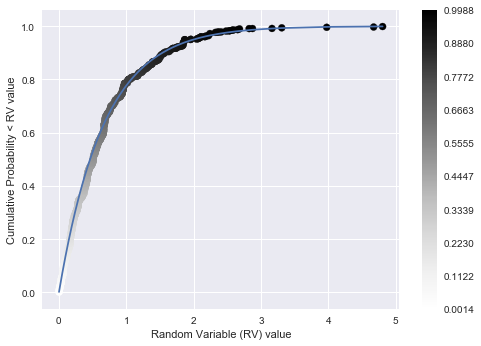

dimensionality of X_val: 	 (100, 1)
dimensionality of Y_val: 	 (100,)
dimensionality of x : 		 (500, 1)
dimensionality of y: 		 (500,) 

1 : TRAIN:  400 TEST:  100
X_train sample: 400 Y_train sample: 400
first entry of sample X_test [ 0.0051629] first entry of sample Y_test 0.0118167940905 

X_train scaling:
mean is:  [ 0.65959584]
variance is:  [ 0.4692637]


X_test scaling:
mean is:  [ 0.63662636]
variance is:  [ 0.33682713]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 540.27 seconds for 10 candidates parameter settings.
Best: 0.011393 using {'weight_constraint': 3, 'neurons': 30, 'learn_rate': 0.1, 'epochs': 500, 'batch_size': 50, 'H_layers': 3}
0.173402 (0.116550) with: {'weight_constraint': 5, 'neurons': 5, 'learn_rate': 0.3, 'epochs': 50, 'batch_size': 10, 'H_layers': 10}
0.067596 (0.049217) with: {'weight_constraint': 3, 'neurons': 3, 'learn_rate': 0.01, 'epochs': 500, 'batch_size': 50, 'H_layers': 2}
0.162658 (0.114313) with: {'weight_

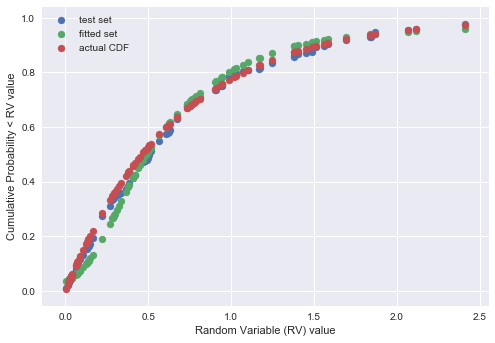

dimensionality of y:  (600,)




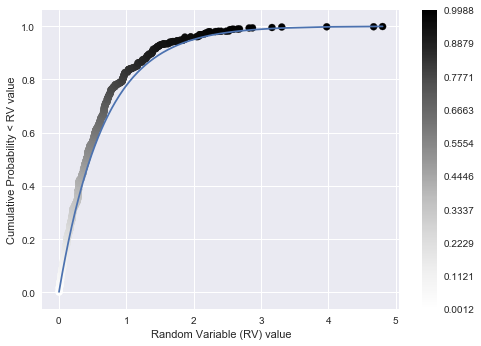

dimensionality of X_val: 	 (100, 1)
dimensionality of Y_val: 	 (100,)
dimensionality of x : 		 (500, 1)
dimensionality of y: 		 (500,) 

2 : TRAIN:  400 TEST:  100
X_train sample: 400 Y_train sample: 400
first entry of sample X_test [ 0.00435382] first entry of sample Y_test 0.0129889703537 

X_train scaling:
mean is:  [ 0.66598745]
variance is:  [ 0.42582997]


X_test scaling:
mean is:  [ 0.65058383]
variance is:  [ 0.45786053]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 561.38 seconds for 10 candidates parameter settings.
Best: 0.005010 using {'weight_constraint': 3, 'neurons': 30, 'learn_rate': 0.1, 'epochs': 500, 'batch_size': 10, 'H_layers': 1}
0.182274 (0.122509) with: {'weight_constraint': 3, 'neurons': 4, 'learn_rate': 0.2, 'epochs': 50, 'batch_size': 25, 'H_layers': 3}
0.016188 (0.018413) with: {'weight_constraint': 3, 'neurons': 5, 'learn_rate': 0.3, 'epochs': 500, 'batch_size': 25, 'H_layers': 1}
0.183419 (0.123068) with: {'weight_

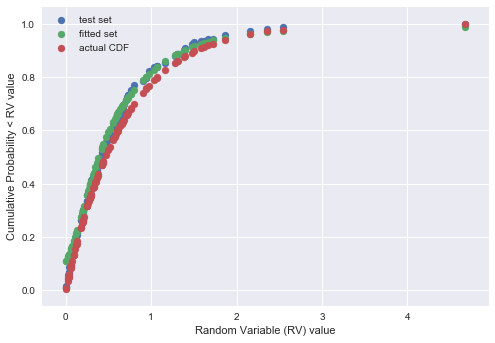

dimensionality of y:  (600,)




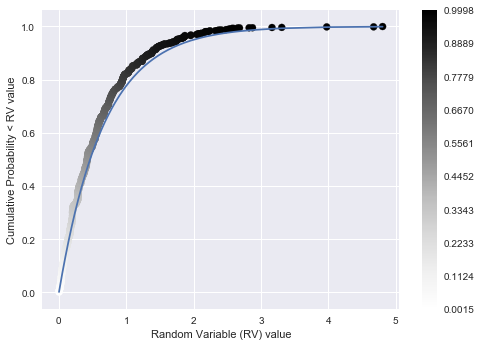

dimensionality of X_val: 	 (100, 1)
dimensionality of Y_val: 	 (100,)
dimensionality of x : 		 (500, 1)
dimensionality of y: 		 (500,) 

3 : TRAIN:  400 TEST:  100
X_train sample: 400 Y_train sample: 400
first entry of sample X_test [ 0.00359001] first entry of sample Y_test 0.00599249099069 

X_train scaling:
mean is:  [ 0.62250364]
variance is:  [ 0.35705286]


X_test scaling:
mean is:  [ 0.68597519]
variance is:  [ 0.5991153]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 902.11 seconds for 10 candidates parameter settings.
Best: 0.023280 using {'weight_constraint': 3, 'neurons': 4, 'learn_rate': 0.01, 'epochs': 500, 'batch_size': 10, 'H_layers': 3}
0.023280 (0.018169) with: {'weight_constraint': 3, 'neurons': 4, 'learn_rate': 0.01, 'epochs': 500, 'batch_size': 10, 'H_layers': 3}
0.146659 (0.100459) with: {'weight_constraint': 3, 'neurons': 5, 'learn_rate': 0.01, 'epochs': 100, 'batch_size': 25, 'H_layers': 3}
0.164077 (0.109940) with: {'weig

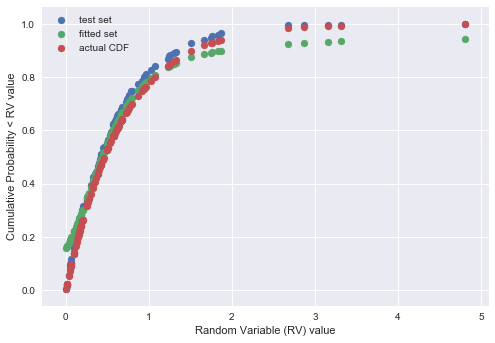

dimensionality of y:  (600,)




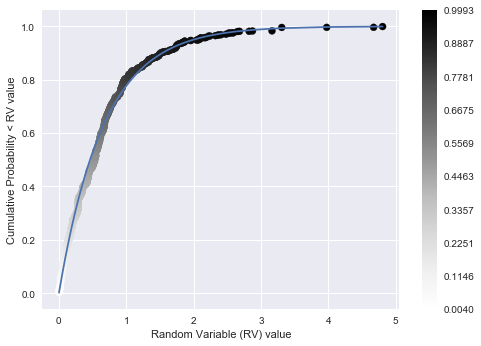

dimensionality of X_val: 	 (100, 1)
dimensionality of Y_val: 	 (100,)
dimensionality of x : 		 (500, 1)
dimensionality of y: 		 (500,) 

4 : TRAIN:  400 TEST:  100
X_train sample: 400 Y_train sample: 400
first entry of sample X_test [ 0.00131766] first entry of sample Y_test 0.00396484588313 

X_train scaling:
mean is:  [ 0.67626534]
variance is:  [ 0.46071655]


X_test scaling:
mean is:  [ 0.60843413]
variance is:  [ 0.32109812]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 1022.21 seconds for 10 candidates parameter settings.
Best: 0.052511 using {'weight_constraint': 3, 'neurons': 3, 'learn_rate': 0.3, 'epochs': 100, 'batch_size': 10, 'H_layers': 2}
0.163697 (0.114281) with: {'weight_constraint': 5, 'neurons': 1, 'learn_rate': 0.001, 'epochs': 500, 'batch_size': 50, 'H_layers': 3}
0.139817 (0.092326) with: {'weight_constraint': 5, 'neurons': 5, 'learn_rate': 0.001, 'epochs': 50, 'batch_size': 100, 'H_layers': 1}
0.175700 (0.117938) with: {'w

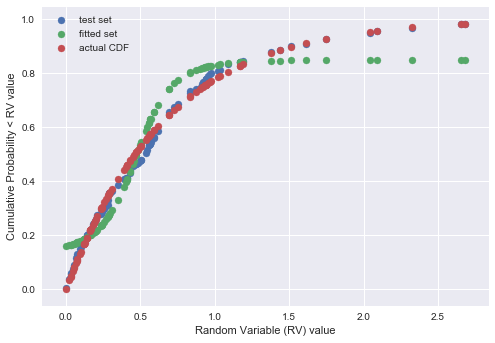

dimensionality of y:  (600,)




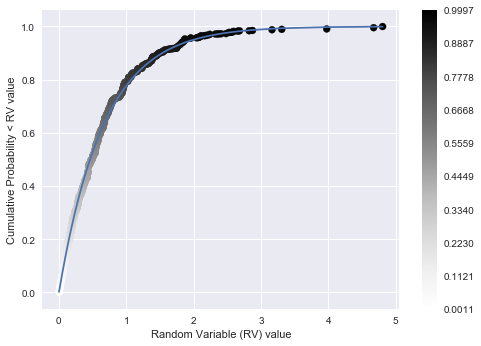

dimensionality of X_val: 	 (100, 1)
dimensionality of Y_val: 	 (100,)
dimensionality of x : 		 (500, 1)
dimensionality of y: 		 (500,) 

5 : TRAIN:  400 TEST:  100
X_train sample: 400 Y_train sample: 400
first entry of sample X_test [ 0.00345194] first entry of sample Y_test 0.00154330084061 

X_train scaling:
mean is:  [ 0.65600361]
variance is:  [ 0.45014093]


X_test scaling:
mean is:  [ 0.69000334]
variance is:  [ 0.39555734]


MLP created
Keras wrapper done
RANDOM SEARCH
Grid is prepared
RandomizedSearchCV took 1078.42 seconds for 10 candidates parameter settings.
Best: 0.008270 using {'weight_constraint': 3, 'neurons': 20, 'learn_rate': 0.01, 'epochs': 50, 'batch_size': 10, 'H_layers': 2}
0.096046 (0.065127) with: {'weight_constraint': 5, 'neurons': 1, 'learn_rate': 0.3, 'epochs': 500, 'batch_size': 25, 'H_layers': 3}
0.020489 (0.018392) with: {'weight_constraint': 5, 'neurons': 20, 'learn_rate': 0.01, 'epochs': 500, 'batch_size': 100, 'H_layers': 5}
0.161994 (0.107608) with: {'w

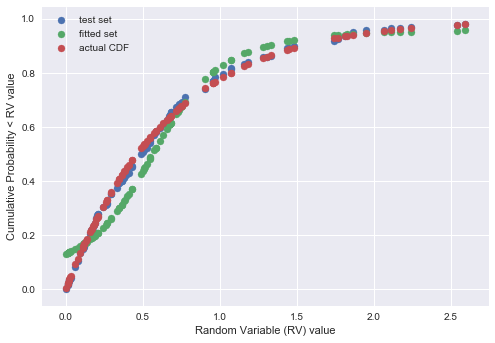

In [4]:
### K-FOLD SIMULATIONS ###

best_score = np.empty([n_split,])
dict_H_layers = np.empty([n_split,])
dict_learn_rate = np.empty([n_split,])
dict_neurons = np.empty([n_split,])
dict_weight_constraint = np.empty([n_split,])
dict_epochs = np.empty([n_split,])
dict_batch_size = np.empty([n_split,])
all_X_test_scaled = np.empty([n_split,int((observations+1-X_val_size-1)/n_split)])
all_predictions = np.empty([n_split,int((observations+1-X_val_size-1)/n_split)])

#create dataset
x_original = create_dataset()
index = np.random.choice(observations+1, X_val_size+1, replace=False)
    
X_val = x_original[index]
#Y_val = y[index]

x = np.delete(x_original, index, 0)
#y = np.delete(y, index, 0)

index_sort = np.argsort(X_val[:,0])
X_val = X_val[index_sort]
#Y_val = Y_val[index_sort]

#print('dimensionality of X_val: \t', np.shape(X_val))
#print('dimensionality of Y_val: \t', np.shape(Y_val))
#print('dimensionality of x : \t\t', np.shape(x))
#print('dimensionality of y: \t\t', np.shape(y), '\n')

kf = KFold(n_splits=n_split, shuffle=True, random_state=None)
kf.get_n_splits(x)
k = 1

print('Simulations')
M = 0
for train_index, test_index in kf.split(x):
    
    #y = np.sort(np.array([random.uniform(0,1) for i in range(0,observations+1)]))
    #y = np.array([0.95*i/observations+0.05 for i in range(0,observations+1)])
    y = create_targetset()
    plot_dataset(x_original, y)

    #take validation set out

    #X_val = x[0:(X_val_size+1)]
    #x = x[(X_val_size+1):(observations+1)]
    #Y_val = y[0:(X_val_size+1)]
    #y = y[(X_val_size+1):(observations+1)]

    #index = [random.randint(0,(observations+1)) for i in range(X_val_size+1)]
    index = np.random.choice(observations+1, X_val_size+1, replace=False)
    
    X_val = x_original[index]
    Y_val = y[index]

    x = np.delete(x_original, index, 0)
    y = np.delete(y, index, 0)

    index_sort = np.argsort(X_val[:,0])
    X_val = X_val[index_sort]
    Y_val = Y_val[index_sort]

    print('dimensionality of X_val: \t', np.shape(X_val))
    print('dimensionality of Y_val: \t', np.shape(Y_val))
    print('dimensionality of x : \t\t', np.shape(x))
    print('dimensionality of y: \t\t', np.shape(y), '\n')
    
    
    
    #create k-fold sets
    print(k, ':', 'TRAIN: ', len(train_index), 'TEST: ', len(test_index))
    #print('TRAIN: ', train_index, 'TEST: ', test_index)
    X_train, X_test = x[train_index], x[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    print('X_train sample:', len(X_train), 'Y_train sample:', len(Y_train))
    print('first entry of sample X_test', X_test[0], 'first entry of sample Y_test', Y_test[0], '\n')

    print('X_train scaling:')
    X_train_scaled = scale(X_train)
    print('X_test scaling:')
    X_test_scaled = scale(X_test)

    MLP = create_model()
    print('MLP created')
    grid, predictions = train_ANN(search, X_train_scaled, Y_train, X_test_scaled)
    plot_cdf(X_train, Y_train, X_test, Y_test, X_train_scaled, X_test_scaled, predictions)
    ###

    best_score[M] = -grid.best_score_
    dict_H_layers[M] = grid.best_params_['H_layers']
    dict_learn_rate[M] = grid.best_params_['learn_rate']
    dict_neurons[M] = grid.best_params_['neurons']
    dict_weight_constraint[M] = grid.best_params_['weight_constraint']
    dict_epochs[M] = grid.best_params_['epochs']
    dict_batch_size[M] = grid.best_params_['batch_size']
    all_predictions[M] = predictions
    all_X_test_scaled[M] = X_test_scaled[:,0]
    
    k += 1
    M += 1

Best error score:  0.00501033191832 

Chosen structure:  { weight_constraint:  3.0 , neurons:  30.0 , learn_rate 0.1 , epochs:  500.0 , batch_size 10.0 , H_layers 1.0 }
Keras wrapper done




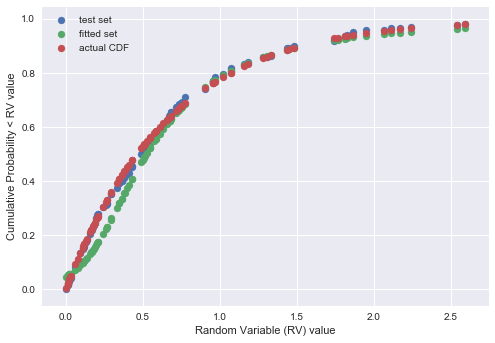

length weights 4
layers length: (weight + possible bias) 30
layers length: (weight + possible bias) 30
layers length: (weight + possible bias) 30
layers length: (weight + possible bias) 1


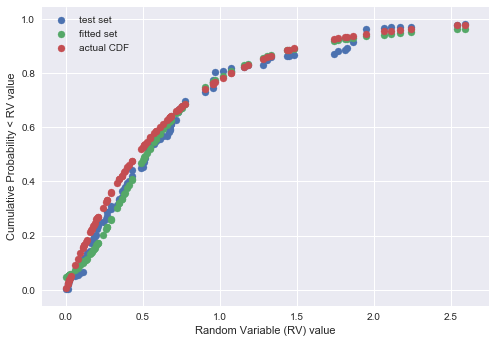

differences between keras and self-constructed-procedure: 
 [  6.32144534e-09   5.00489161e-09   8.31462933e-09   1.36703954e-08
   5.97212417e-09   1.70149138e-08   1.00324390e-08   6.92757786e-09
   4.32799833e-08   9.08620629e-09   6.52085894e-09   4.18009612e-08
   9.50940519e-09   2.09155920e-08   1.01666143e-08   1.18658759e-08
   1.00271966e-08   3.78541933e-09   3.72930958e-09   7.62607980e-09
   7.68403507e-09   2.93776524e-08   3.39651521e-08   1.36792495e-08
   1.48387244e-08   2.85624236e-08   5.31191802e-08   3.34949956e-08
   5.79248247e-09   1.59570822e-08   4.63599962e-08   4.39421992e-08
   3.33726585e-09   8.67143479e-09   2.69268891e-09   1.41618802e-08
   1.02841430e-08   1.16949388e-08   5.75251938e-08   3.02312393e-08
   6.77673487e-08   1.04819525e-08   1.75353013e-08   2.58664175e-08
   3.44447465e-09   1.17676249e-08   2.10421886e-08   2.33287498e-08
   7.21978232e-08   7.29290245e-08   4.71240971e-08   4.35531563e-08
   3.63020604e-08   4.88416033e-08   5.0585

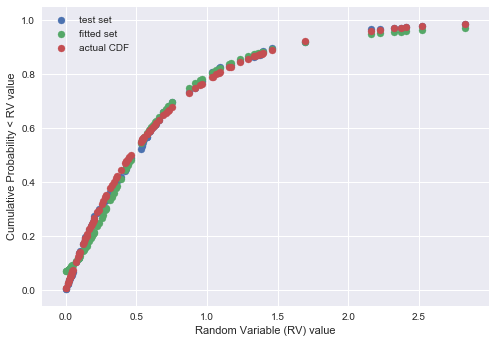

In [5]:
#choose structure for MLP
print("Best error score: ", np.amin(best_score), "\n")
print("Chosen structure: ", '{ weight_constraint: ',dict_weight_constraint[np.argmin(best_score)],', neurons: ', dict_neurons[np.argmin(best_score)], ', learn_rate', dict_learn_rate[np.argmin(best_score)], ', epochs: ', dict_epochs[np.argmin(best_score)], ', batch_size', dict_batch_size[np.argmin(best_score)], ', H_layers', dict_H_layers[np.argmin(best_score)],'}' )

# fix hyperparameters
weight_constraint = int(dict_weight_constraint[np.argmin(best_score)])
neurons = int(dict_neurons[np.argmin(best_score)])
learn_rate = dict_learn_rate[np.argmin(best_score)]
epochs = int(dict_epochs[np.argmin(best_score)])
batch_size = int(dict_batch_size[np.argmin(best_score)])
H_layers = int(dict_H_layers[np.argmin(best_score)])

#run on last test set ONLY (?)
model, predictions = run_ANN(X_train_scaled, Y_train, X_test_scaled)
plot_cdf(X_train, Y_train, X_test, Y_test, X_train_scaled, X_test_scaled, predictions)

#retrieve these weights
#(map weights MLP to validation set)
weights = model.get_weights()
print("length weights", len(weights))
for i in range(len(weights)):
    print("layers length: (weight + possible bias)", weights[i].size)

#print(model.get_weights())
#print(model.get_config())

### CHECK PROCEDURE ON TEST SET ###
temp_not_saved, Tpredictions = run_ANN_manually(X_test, X_test_scaled)
### WARNING (still small differences)
np.in1d(predictions,Tpredictions)
diff = predictions[:,0]-Tpredictions
print('differences between keras and self-constructed-procedure: \n', abs(diff))

### MAP TESTWEIGHTS ON VALSET ###
print('X_val scaling:')
X_val_scaled = scale(X_val)
temp_saved, predictions = run_ANN_manually(X_val, X_val_scaled)

In [8]:
def derivative_revised(): 
    #i = len(temp_saved[0])-1
    triangle = H_layers -1
    heart = len(weights)-2
    print('iterator temp_saved triangle: ', triangle, 'iterator weights heart: ', heart)

    #temp_layers (neurons middle layers)
    if H_layers > 1:
        print('STEP LAYERS')
        saved_layers = dict()
        for q in range(0, (H_layers-1)):
            print('NEW LAYER')
            print('q', q)
            saved_layers[q] = np.zeros([len(predictions), neurons])
            if(q==0):
                #print('IF')
                for obs in range(len(predictions)):
                    #print('NEW OBS')
                    #print('obs', obs)
                    for j in range(neurons):
                        #print('j', j)
                        temp_layers = 0
                        for k in range(neurons):
                            #print('k', k)
                            temp_sum = 0
                            for p in range(neurons):
                                #print('p', p)
                                temp_sum += temp_saved[obs][triangle][p]*weights[heart-2][p][k]
                            temp_sum += weights[heart-1][k]
                            temp_layers += weights[heart][k][0]*derivative_sigmoid(temp_sum)*weights[heart-2][j][k]
                        saved_layers[q][obs][j] = temp_layers
            else: 
                #print('ELSE')
                for obs in range(len(predictions)):
                    #print('NEW OBS')
                    #print('obs', obs)
                        for j in range(neurons):
                            #print('j', j)
                            temp_layers = 0
                            for k in range(neurons):
                                #print('k', k)
                                temp_sum = 0
                                for p in range(neurons):
                                    #print('p', p)
                                    temp_sum += temp_saved[obs][triangle][p]*weights[heart-2][p][k]
                                temp_sum += weights[heart-1][k]
                                temp_layers += saved_layers[q-1][obs][k]*derivative_sigmoid(temp_sum)*weights[heart-2][j][k]
                            saved_layers[q][obs][j] = temp_layers
        heart -= 2
        triangle -= 1

    print('iterator temp_saved triangle: ', triangle, 'iterator weights heart: ', heart)

    #derivative input layer
    print('LAST STEP')
    saved_last = np.zeros([len(predictions), N_nodes[t]])
    for obs in range(len(predictions)):
        #print('NEW OBS')
        #print('obs', obs)
        for i in range(N_nodes[t]):
            #print('i', i)
            temp_last = 0
            if (H_layers == 1):
                #print('IF')
                for k in range(neurons):
                    #print('k', k)
                    temp_sum = 0
                    for p in range(N_nodes[t]):
                        #print('p', p)
                        #print('weights[0][p][k]', 'weights[0][',p,'][',k,']')
                        #print('X_val[obs][p]', 'X_val[obs][',p,']')
                        temp_sum += weights[0][p][k]*X_val[obs][p]
                    #print('BIAS weights[1][k]', 'weights[1][',k,']')
                    temp_sum += weights[1][k]
                    #print('derivative_sigmoid')
                    #print('weights[2][k][0]', 'weights[2][',k,'][0]')
                    #print('weights[0][i][k]', 'weights[0][',i,'][',k,']')
                    temp_last += weights[2][k][0]*derivative_sigmoid(temp_sum)*weights[0][i][k]
                    #print('temp_last', temp_last)
                #print('saved_last[obs][i]', 'saved_last[obs][',i,']')
                saved_last[obs][i] = temp_last       
            else:
                #print('ELSE')
                for k in range(neurons):
                    #print('k', k)
                    temp_sum = 0
                    for p in range(N_nodes[t]):
                        #print('p', p)
                        temp_sum += weights[0][p][k]*X_val[obs][p]
                    temp_sum += weights[1][k]
                    temp_last += saved_layers[q-1][obs][k]*derivative_sigmoid(temp_sum)*weights[0][i][k]
                saved_last[obs][i] = temp_last 

    return saved_last

iterator temp_saved triangle:  0 iterator weights heart:  2
iterator temp_saved triangle:  0 iterator weights heart:  2
LAST STEP
NEW OBS
obs 0
i 0
IF
NEW OBS
obs 1
i 0
IF
NEW OBS
obs 2
i 0
IF
NEW OBS
obs 3
i 0
IF
NEW OBS
obs 4
i 0
IF
NEW OBS
obs 5
i 0
IF
NEW OBS
obs 6
i 0
IF
NEW OBS
obs 7
i 0
IF
NEW OBS
obs 8
i 0
IF
NEW OBS
obs 9
i 0
IF
NEW OBS
obs 10
i 0
IF
NEW OBS
obs 11
i 0
IF
NEW OBS
obs 12
i 0
IF
NEW OBS
obs 13
i 0
IF
NEW OBS
obs 14
i 0
IF
NEW OBS
obs 15
i 0
IF
NEW OBS
obs 16
i 0
IF
NEW OBS
obs 17
i 0
IF
NEW OBS
obs 18
i 0
IF
NEW OBS
obs 19
i 0
IF
NEW OBS
obs 20
i 0
IF
NEW OBS
obs 21
i 0
IF
NEW OBS
obs 22
i 0
IF
NEW OBS
obs 23
i 0
IF
NEW OBS
obs 24
i 0
IF
NEW OBS
obs 25
i 0
IF
NEW OBS
obs 26
i 0
IF
NEW OBS
obs 27
i 0
IF
NEW OBS
obs 28
i 0
IF
NEW OBS
obs 29
i 0
IF
NEW OBS
obs 30
i 0
IF
NEW OBS
obs 31
i 0
IF
NEW OBS
obs 32
i 0
IF
NEW OBS
obs 33
i 0
IF
NEW OBS
obs 34
i 0
IF
NEW OBS
obs 35
i 0
IF
NEW OBS
obs 36
i 0
IF
NEW OBS
obs 37
i 0
IF
NEW OBS
obs 38
i 0
IF
NEW OBS
obs 39
i 0
IF


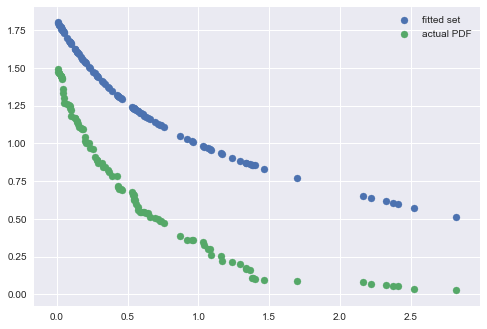

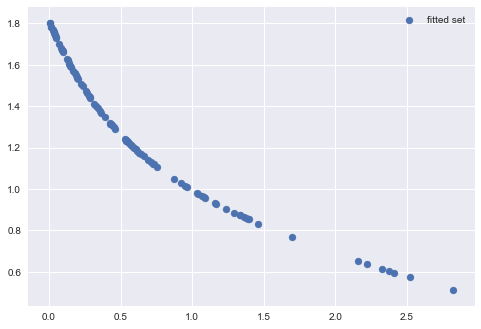

In [9]:
### DERIVATIVE H=? ###
outcome = derivative_revised()

for i in range(N_nodes[t]):
    #plt.scatter(X_val_scaled, temp_last[:,0], label="scaled fitted set")
    #plt.scatter(X_val_scaled, expon.pdf(X_test,scale=1/lambd), label="scaled actual PDF")
    plt.scatter(X_val[:,i], outcome[:,i], label="fitted set")
    plt.scatter(X_val[:,i], expon.pdf(X_test[:,i],scale=1/lambd), label="actual PDF")
    plt.legend()
    plt.show()

for i in range(N_nodes[t]):
    plt.scatter(X_val[:,i], outcome[:,i], label="fitted set")
    plt.legend()
    plt.show()